# Lens parameters

Here I try to generalize the properties of different lens and try to understand the relation between different lens parameters.

~ Saif 08/2021

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from gw_lens_dir.L_unlensed import Lunlensed
from gw_lens_dir.overlap_lensing_changed_param import overlap_dual_ann_lensing
%matplotlib inline

In [2]:
data_path = '/Users/saifali/Desktop/gwlensing/data/'

### Point mass lens

Refer to section 2.1 in Takahashi-Nakamura

In [3]:
solar_mass = 4.92624076 * 10**-6 #[solar_mass] = sec

def mag(ml, y, lens):
    
    if lens == 'pm':
        mu_plus = np.abs(0.5 + (y ** 2 + 2) / (2 * y * (y ** 2 + 4) ** 0.5))
        mu_minus = np.abs(0.5 - (y ** 2 + 2) / (2 * y * (y ** 2 + 4) ** 0.5))
    
    elif lens == 'sis':
        mu_plus = np.abs(1 + 1 / y)
        mu_minus = np.abs(-1 + 1 / y)
    
    return mu_plus, mu_minus

def td(ml, y, lens):
    
    if lens == 'pm':
        first_term = (y * (y ** 2 + 4) ** 0.5) / 2
        second_term = np.log(((y ** 2 + 4) ** 0.5 + y) / ((y ** 2 + 4) ** 0.5 - y))
        tds = 4 * ml * (first_term + second_term)
    
    elif lens == 'sis':
        tds = 8 * ml * y
    
    return tds

In [4]:
print(mag(1e3, 0.01, 'pm')[1] / mag(1e3, 0.5, 'pm')[0])
print(td(1e3, 0.01, 'pm'))

31.10566431960542
80.0003333320829


In [5]:
y = np.linspace(0.1, 1, 50)
ml = [10 * solar_mass, 50 * solar_mass, 100 * solar_mass]

flux_ratio_pm_1 = np.zeros_like(y)
flux_ratio_pm_2 = np.zeros_like(y)
flux_ratio_sis_1 = np.zeros_like(y)
flux_ratio_sis_2 = np.zeros_like(y)
tds_pm_1 = np.zeros_like(y)
tds_pm_2 = np.zeros_like(y)
tds_sis_1 = np.zeros_like(y)
tds_sis_2 = np.zeros_like(y)

for i in range(y.shape[0]):
    flux_ratio_pm_1[i] = mag(ml[0], y[i], lens = 'pm')[1] / mag(ml[0], y[i], lens = 'pm')[0]
    flux_ratio_pm_2[i] = mag(ml[1], y[i], lens = 'pm')[1] / mag(ml[1], y[i], lens = 'pm')[0]
    flux_ratio_sis_1[i] = mag(ml[0], y[i], lens = 'sis')[1] / mag(ml[0], y[i], lens = 'sis')[0]
    flux_ratio_sis_2[i] = mag(ml[1], y[i], lens = 'sis')[1] / mag(ml[1], y[i], lens = 'sis')[0]
    tds_pm_1[i] = td(ml[0], y[i], lens = 'pm')
    tds_pm_2[i] = td(ml[1], y[i], lens = 'pm')
    tds_sis_1[i] = td(ml[0], y[i], lens = 'sis')
    tds_sis_2[i] = td(ml[1], y[i], lens = 'sis')

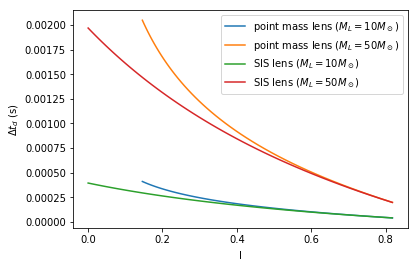

In [6]:
#plt.figure(figsize = (10, 7))
plt.plot(flux_ratio_pm_1, tds_pm_1, label = r'point mass lens $(M_L = 10 M_\odot)$')
plt.plot(flux_ratio_pm_2, tds_pm_2, label = r'point mass lens $(M_L = 50 M_\odot)$')
plt.plot(flux_ratio_sis_1, tds_sis_1, label = r'SIS lens $(M_L = 10 M_\odot)$')
plt.plot(flux_ratio_sis_2, tds_sis_2, label = r'SIS lens $(M_L = 50 M_\odot)$')
plt.xlabel(r'$\mathrm{I}$')
plt.ylabel(r'$\Delta t_d$ (s)')
#plt.savefig('I-td_relation.png', dpi = 100, bbox_inches = 'tight')
plt.legend();  

The figure above shows the time delay as a function of flux ratio of the double-image case. We used point mass and SIS lens with two different lens mass values of 10 solar_mass and 50 solar_mass. We can see that as the flux ratio is increasing the time delay between the two images is getting close to zero which is what we expect if we see two images of same magnification. We also notice that as we increase the mass of a particular lens, the curve is shifted upwards. This means that for a particular flux ratio of images observed, for let's say SIS lens, the time delay will be higher due to high mass of the lens. 

In [7]:
solar_mass = 4.92624076 * 10**-6 #[solar_mass] = sec
giga_parsec = 1.02927125 * 10**17 #[giga_parsec] = sec

default_strain_params = {
    'theta_s': 0.,
    'phi_s': 0.,
    'theta_l': 0.,
    'phi_l': 0.,
    'mcz': 18.79 * solar_mass,
    'dist': 1.58 * giga_parsec,
    'eta': 0.25,
    'tc': 0.,
    'phi_c': 0.
}
model = Lunlensed(default_strain_params)

In [25]:
def snr(ml, y, lens):
    
    M = (default_strain_params['mcz'] /np.power(default_strain_params['eta'], 3/5))
    low_limit = 20
    upper_limit = 1 / (np.power(6, 3/2) * np.pi * M)
    
    
    
    if lens == 'pm':
        amp_fact_pm = lambda f: np.sqrt(mag(ml, y, lens)[0]) - 1j * np.sqrt(mag(ml, y, lens)[1]) * \
                    np.exp(2 * np.pi * 1j * f * td(ml, y, lens))
        integrand = lambda f: np.power(np.abs(model.hI(f) * amp_fact_pm(f)), 2) / model.Sn(f)

        snr_temp, snr_err = sp.integrate.quad(integrand, low_limit, upper_limit)
        snr_sq = 4 * snr_temp
        snr = np.sqrt(snr_sq)
        
    return snr, low_limit, upper_limit

In [26]:
snr(1e4 * solar_mass, y = 0.5, lens = 'pm')

(23.805743890913412, 20, 101.84620327015129)

In [ ]:
def contour_plot(ml_low_limit, 
                 ml_up_limit, 
                 y_low_limit, 
                 y_up_limit,
                 lens, 
                 pts = 70): 
    
    """ lens param should be string ('pm' or 'sis') 
    """
    
    ml_mesh, y_mesh = np.meshgrid(np.linspace(ml_low_limit, ml_up_limit, pts), np.linspace(y_low_limit, y_up_limit, pts))
    ml_flatten = ml_mesh.flatten()
    y_flatten = y_mesh.flatten()
    snr_flat = np.zeros_like(y_flatten)

    for i in range(ml_flatten.shape[0]):
        snr_flat[i] = snr(ml_flatten[i], y_flatten[i], lens = lens)[0]
        
    snr_mesh = snr_flat.reshape(pts, pts)
    
    td_mesh = np.array([td(ml_flatten[i], y_flatten[i], lens = lens) for i in range(ml_flatten.shape[0])]).reshape(pts, pts)
    flux_ratio_mesh = np.array([mag(ml_flatten[i], y_flatten[i], lens = lens)[1] / mag(ml_flatten[i], y_flatten[i], lens = lens)[0] for i in range(ml_flatten.shape[0])]).reshape(pts, pts)
    
    plt.figure(figsize = (10, 8))
    ax1 = plt.subplot(211)
    cs1 = ax1.contour(flux_ratio_mesh, td_mesh ,snr_mesh, 30)
    ax1.set(ylabel = 'td', xlabel = 'flux_ratio')
    ax1.clabel(cs1, inline=True, fontsize=10)
    #plt.plot(flux_ratio_pm_1, tds_pm_1, label = 'point mass 10 solar_mass')
    #plt.plot(flux_ratio_pm_2, tds_pm_2, label = 'point mass 50 solar_mass')

    ax2 = plt.subplot(212)
    cs2 = ax2.contour(y_mesh, ml_mesh, snr_mesh, 30)
    ax2.set(ylabel = 'ml', xlabel = 'y')
    ax2.clabel(cs2, inline=True, fontsize=10)
  
    return ml_flatten, y_flatten, snr_flat

In [ ]:
z = contour_plot(1e2 * solar_mass,
                 1e4 * solar_mass,
                 0.1, 
                 1,
                 lens = 'pm'
                )

In [ ]:
td(100 * solar_mass, 0.5, 'pm')

In [ ]:
z[2][np.argmin(z[2])]

### Mismatch (for new parameters)

* Redefining the parameters for the lens. (y, $M_L$) --> (I, $t_d$)
> $\Large F(f) = |\mu_+|^{1/2} (1 - i I^{1/2} e^{2 \pi i f \Delta t_d}) = |\mu_+|^{1/2} G(f)$

*** 

* Overlap (for redefined amplification factor)
>$\Large \mathcal{O} = \frac{4 Re \int \frac{h_t^{* UL}(f) G(f) h_m^{UL}(f)}{Sn(f)} df}{\left[\left(4 Re \int \frac{h_t^{* UL}(f) h_t^{UL}(f)}{Sn(f)} df \right) \left(4 Re \int \frac{h_m^{* UL}(f) G^*(f) G(f) h_m^{UL}(f)}{Sn(f)} df \right)\right] ^ {1/2}}$

In [3]:
solar_mass = 4.92624076 * 10**-6 #[solar_mass] = sec
giga_parsec = 1.02927125 * 10**17 #[giga_parsec] = sec
year = 31557600 #[year] = sec

initial_params_source = {
    'theta_s_source' : 0.0, 
    'phi_s_source' : 0.0, 
    'theta_l_source' : 0.0, 
    'phi_l_source' : 0.0, 
    'mcz_source' : 28.79 * solar_mass, 
    'dist_source': 1.58 * giga_parsec, 
    'eta_source' : 0.25, 
    't0' : 0.0, 
    'phi_0' : 0.0,
    'td':0.81,
    'flux_ratio': 0.39
}

initial_params_template = {
    'theta_s_temp' : 0.0, 
    'phi_s_temp' : 0.0, 
    'theta_l_temp' : 0.0, 
    'phi_l_temp' : 0.0, 
    'mcz_temp' : 28.79 * solar_mass, 
    'dist_temp': 1.58 * giga_parsec, 
    'eta_temp' : 0.25, 
    #'tc' : 0.0, 
    #'phi_c' : 0.0,
}
new_param_ini = overlap_dual_ann_lensing(params_source = initial_params_source, params_temp = initial_params_template)
F = new_param_ini.F_geo_source_pm(20)
print(F)
overlap = new_param_ini.overlap(x = (0., 0.))
overlap

(1.5939346040626994-0.19298105113426173j)


/Users/saifali/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:448: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


-0.8476813440833333

In [4]:
freq = np.linspace(20, 102, 200)
signal_source = np.zeros_like(freq, dtype = np.complex128)
signal_temp = np.zeros_like(freq, dtype = np.complex128)

new_param_ini = overlap_dual_ann_lensing(params_source = initial_params_source, params_temp = initial_params_template)
for i in range(len(freq)):
    signal_source[i] = new_param_ini.signal_source(freq[i], 0, 0)
    signal_temp[i] = new_param_ini.signal_temp(freq[i], 0, 0)

In [5]:
limit = new_param_ini.limit(initial_params_source, initial_params_template)
limit

(20, 66.47065506933457, 66.47065506933457, 66.47065506933457)

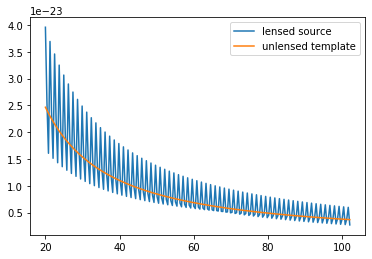

In [6]:
plt.plot(freq, np.abs(signal_source), label = 'lensed source')
plt.plot(freq, np.abs(signal_temp), label = 'unlensed template')
plt.legend()

In [7]:
freq = np.linspace(20, 102, 200)
integrand_1 = np.zeros_like(freq, dtype = np.complex128)
integrand_2 = np.zeros_like(freq, dtype = np.complex128)
integrand_3 = np.zeros_like(freq, dtype = np.complex128)

new_param_ini = overlap_dual_ann_lensing(params_source = initial_params_source, params_temp = initial_params_template)
for i in range(len(freq)):
    integrand_1[i] = new_param_ini.integrand_1(freq[i], 0, 0)
    integrand_2[i] = new_param_ini.integrand_2(freq[i], 0, 0)
    integrand_3[i] = new_param_ini.integrand_3(freq[i], 0, 0)

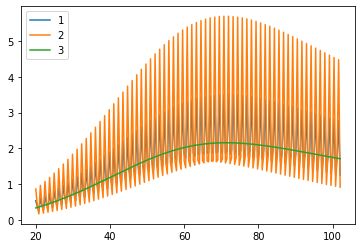

In [8]:
plt.plot(freq, np.abs(integrand_1), label = '1')
plt.plot(freq, np.abs(integrand_2), label = '2')
plt.plot(freq, np.abs(integrand_3), label = '3')
plt.legend()

* Overlap estimation at the plateau (fix I)

> $\Large \mathcal{O} = \frac{|\mu_+|^{1/2}}{(|\mu_+| + |\mu_-|)^{1/2}} = \frac{1}{\sqrt{1 + I}}$

In [16]:
data_file = 'overlap_lensing_td.csv'
df = pd.read_csv(data_path + data_file, header = None, converters = {1: eval})
df['match'] = np.array([-df[1][i][0] for i in range(len(df))])

In [17]:
data_file = 'overlap_lensing_td_I=0.4.csv'
df_2 = pd.read_csv(data_path + data_file, header = None, converters = {1: eval})
df_2['match'] = np.array([-df_2[1][i][0] for i in range(len(df_2))])

In [18]:
data_file = 'overlap_lensing_td_I=0.8_mcz=12.79.csv'
df_3 = pd.read_csv(data_path + data_file, header = None, converters = {1: eval})
df_3['match'] = np.array([-df_3[1][i][0] for i in range(len(df_3))])

In [19]:
data_file = 'overlap_lensing_td_I=0.8_mcz=28.79.csv'
df_4 = pd.read_csv(data_path + data_file, header = None, converters = {1: eval})
df_4['match'] = np.array([-df_4[1][i][0] for i in range(len(df_4))])

***************************************************

In [20]:
data_file = 'overlap_lensing_td_I=0.4_mcz=12.79.csv'
df_5 = pd.read_csv(data_path + data_file, header = None, converters = {1: eval})
df_5['match'] = np.array([-df_5[1][i][0] for i in range(len(df_5))])
df_5 = df_5.sort_values(by = 0)

In [21]:
data_file = 'overlap_lensing_td_I=0.4_mcz=18.79.csv'
df_6 = pd.read_csv(data_path + data_file, header = None, converters = {1: eval})
df_6['match'] = np.array([-df_6[1][i][0] for i in range(len(df_6))])
df_6 = df_6.sort_values(by = 0)

In [22]:
data_file = 'overlap_lensing_td_I=0.4_mcz=28.79.csv'
df_7 = pd.read_csv(data_path + data_file, header = None, converters = {1: eval})
df_7['match'] = np.array([-df_7[1][i][0] for i in range(len(df_7))])
df_7 = df_7.sort_values(by = 0)

Text(0.5, 0, '$log(\\Delta t_d)$')

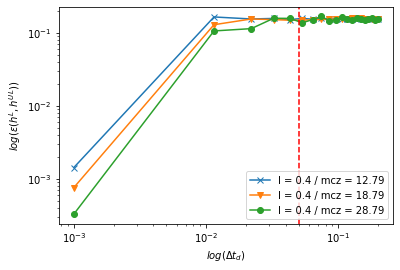

In [23]:
plt.loglog(df_5[0], 1 - df_5['match'], marker = 'x', label = 'I = 0.4 / mcz = 12.79')
plt.loglog(df_6[0], 1 - df_6['match'], marker = 'v', label = 'I = 0.4 / mcz = 18.79')
plt.loglog(df_7[0], 1 - df_7['match'], marker = 'o', label = 'I = 0.4 / mcz = 28.79')
plt.axvline(x=0.05, color='r', linestyle='--')
plt.legend(loc = 4)
plt.ylabel('$log(\epsilon(h^L, h^{UL}))$')
plt.xlabel('$log(\Delta t_d)$')

In [26]:
#plt.scatter(df[0], 1 - df['match'], label = 'I = 0.8 / mcz = 18.79')
#plt.scatter(df_2[0], 1 - df_2['match'], label = 'I = 0.4') # td = [0.001, 0.5]
#plt.scatter(df_3[0], 1 - df_3['match'], label = 'I = 0.8 / mcz = 12.79')
#plt.scatter(df_4[0], 1 - df_4['match'], label = 'I = 0.8 / mcz = 28.79')
#plt.legend(loc = 4)

In [5]:
data_file = 'overlap_lensing_I_td=0.1.csv'
df_I = pd.read_csv(data_path + data_file, header = None, converters = {1: eval})
df_I['match'] = np.array([-df_I[1][i][0] for i in range(len(df_I))])

In [6]:
data_file = 'overlap_lensing_I_td=0.05.csv'
df_I_1 = pd.read_csv(data_path + data_file, header = None, converters = {1: eval})
df_I_1['match'] = np.array([-df_I_1[1][i][0] for i in range(len(df_I_1))])

In [7]:
data_file = 'overlap_lensing_I_td=0.08.csv'
df_I_2 = pd.read_csv(data_path + data_file, header = None, converters = {1: eval})
df_I_2['match'] = np.array([-df_I_2[1][i][0] for i in range(len(df_I_2))])
df_I_2

,0,1,match
0,0.289474,"[-0.8787558594442619, -0.00012074237837790188,...",0.878756
1,1.000000,"[-0.7007171888881872, -0.00023176395856823578,...",0.700717
2,0.384211,"[-0.847358609676222, -0.00013988308705526254, ...",0.847359
3,0.478947,"[-0.8189887965167628, -0.00015699169812847044,...",0.818989
4,0.952632,"[-0.709474745427362, -0.00022597056597732597, ...",0.709475
5,0.715789,"[-0.7585704978028781, -0.00019405945047175832,...",0.758570
6,0.857895,"[-0.7279846059386642, -0.00021370714132523398,...",0.727985
7,0.905263,"[-0.7185570915430036, -0.00021989608742280922,...",0.718557
8,0.431579,"[-0.8328255962881719, -0.0001486501853211804, ...",0.832826
9,0.573684,"[-0.7931976377270421, -0.0001726299587639234, ...",0.793198


In [11]:
# relation between mismatch and flux ratio at plateau (fix time delay)
def mismatch(I):
    return 1 - ((1 + I) ** (-1/2))

In [12]:
I = np.linspace(0.1, 1, 100)
eps = np.zeros_like(I)

for i in range(len(I)):
    eps[i] = mismatch(I[i])

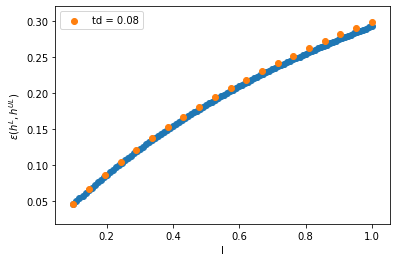

In [16]:
plt.scatter(I, eps)
plt.scatter(df_I_2[0], 1 - df_I_2['match'], label = 'td = 0.08')
plt.xlabel('I')
plt.ylabel('$\epsilon(h^L, h^{UL})$')
plt.legend()